# Loading and EDA of 'insurance_test.csv', 'insurance_train.csv' files

In [2]:
!git clone https://github.com/AliaksandraLabko/ML.git

fatal: destination path 'ML' already exists and is not an empty directory.


In [3]:
%cd ML

C:\Users\stran\AppData\Local\Programs\Microsoft VS Code\ML


C:\Users\stran\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
# import all the libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek

from sklearn.svm import SVC


In [5]:
print("Current directory:", os.getcwd())  # Should end with '.../ML'
print("Files in directory:", os.listdir())

Current directory: C:\Users\stran\AppData\Local\Programs\Microsoft VS Code\ML
Files in directory: ['.git', 'insurance_test.csv', 'insurance_train.csv', 'ML02_data_preparation.ipynb', 'README.md', 'svm_test_predictions.csv']


In [6]:
# lets import data
INS_test = pd.read_csv("insurance_test.csv")
INS = pd.read_csv("insurance_train.csv")


INS.head(10) # Shows the first 10 rows of the dataset

,reward,claim_status,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
0,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.284509,50b3e71e,51,united states,105.459587,SecurePlan Flex,21
1,18.428627,0,9b2d5b46,type_a,web,0,agt_0001,0.207538,96d6c6df,32,spain,30.433459,DriveSafe Rental Addon,6
2,0.000000,0,9b2d5b46,type_a,web,1,agt_0004,0.300461,50b3e71e,38,new zealand,78.728474,TripGuard Cancel,84
3,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.132404,50b3e71e,30,thailand,17.146843,TripGuard Cancel,39
4,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.070443,50b3e71e,37,viet nam,10.476416,TripGuard Cancel,48
5,41.613029,0,9b2d5b46,type_a,web,1,agt_0001,0.288280,96d6c6df,30,australia,68.698795,DriveSafe Rental Addon,59
6,46.687680,0,9b2d5b46,type_a,web,1,agt_0001,0.140587,96d6c6df,23,croatia,79.426319,DriveSafe Rental Addon,37
7,0.000000,0,9b2d5b46,type_a,web,1,agt_0004,0.189089,50b3e71e,38,malaysia,20.088002,SecurePlan OneWay,18
8,10.186860,0,f67ab10a,type_b,web,1,agt_0002,0.097472,7b5dbb09,35,indonesia,28.631036,TravelShield Basic,10
9,9.335454,0,f67ab10a,type_b,web,2,agt_0005,0.083457,99ede4e4,28,singapore,37.609526,TravelShield Core,138


In [7]:
# the structure of the dataset
INS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56993 entries, 0 to 56992
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                56993 non-null  float64
 1   claim_status          56993 non-null  int64  
 2   person_gender         56993 non-null  object 
 3   entity_type           56993 non-null  object 
 4   channel               56993 non-null  object 
 5   support_interactions  56993 non-null  int64  
 6   agent_id              56993 non-null  object 
 7   customer_score        56993 non-null  float64
 8   entity_a              56993 non-null  object 
 9   person_age            56993 non-null  int64  
 10  location              56993 non-null  object 
 11  revenue               56993 non-null  float64
 12  product_id            56993 non-null  object 
 13  trip_length           56993 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 6.1+ MB


In [8]:
# Basic statistics for numerical features
print(INS.describe())

# Value counts for categorical features
cat_cols = ['person_gender', 'entity_type', 'channel', 'agent_id', 'entity_a', 'location', 'product_id']
for col in cat_cols:
    print(f"\n{col} value counts:")
    print(INS[col].value_counts())  # Top 10 categories

             reward  claim_status  support_interactions  customer_score  \
count  56993.000000  56993.000000          56993.000000    56993.000000   
mean       9.794976      0.014633              1.093941        0.189540   
std       19.791119      0.120081              0.923113        0.080641   
min        0.000000      0.000000              0.000000        0.000000   
25%        0.000000      0.000000              0.000000        0.136389   
50%        0.000000      0.000000              1.000000        0.181041   
75%       11.336612      0.000000              2.000000        0.230836   
max      282.073580      1.000000              6.000000        1.000000   

         person_age       revenue   trip_length  
count  56993.000000  56993.000000  56993.000000  
mean      39.697261     40.750070     49.234888  
std       12.603433     48.749221     98.659469  
min       18.000000   -406.642669      1.000000  
25%       34.000000     18.246389      9.000000  
50%       36.000000     

'Channel' has near zero variance - i'd remove this value.  And combine 'location' that is under 1% var into category 'other'.

### Missing values

Lets check the existence of missing values

In [12]:
INS.isnull().sum()

reward                  0
claim_status            0
person_gender           0
entity_type             0
channel                 0
support_interactions    0
agent_id                0
customer_score          0
entity_a                0
person_age              0
location                0
revenue                 0
product_id              0
trip_length             0
dtype: int64

As we don't have any missing values, we can proceed further.

### Distributions of nominal variables

Lets check the frequencies of individual levels of all the nominal variables.

Extremely small counts of single levels are problematic as they might be very rare cases which a model will not be able to learn how they influence the sale price.

Therefore we will replace all the levels which have no more than 569 observations (ca. 1% of the total sample) with the label "other".




In [9]:
# Lets check the frequencies of individual levels of all the nominal variables

# Based on the information about the dataset we can list all nominal variables

nominal_variables = ['person_gender', 'entity_type', 'channel', 'agent_id', 'entity_a', 'location', 'product_id']

# Loop through each nominal variable
for var in nominal_variables:
    # Get the value counts for each category in the variable
    value_counts = INS[var].value_counts()
    print("\n")
    print(INS[var].value_counts(dropna = False))



person_gender
9b2d5b46    40643
08f27188     8379
f67ab10a     7971
Name: count, dtype: int64


entity_type
type_a    41297
type_b    15696
Name: count, dtype: int64


channel
web       56019
retail      974
Name: count, dtype: int64


agent_id
agt_0004    31663
agt_0001     7713
agt_0005     7444
agt_0002     5683
agt_0008      949
agt_0006      672
agt_0007      651
agt_0013      612
agt_0015      456
agt_0003      356
agt_0009      297
agt_0011      175
agt_0000       89
agt_0014       85
agt_0010       77
agt_0012       71
Name: count, dtype: int64


entity_a
50b3e71e    31663
96d6c6df     7713
99ede4e4     7444
7b5dbb09     5683
b5e4bb23      949
1e089e14      672
c4e0e538      651
f94f3b95      612
5d630515      456
d1e2553c      356
be00235a      297
aba20dea      175
0c4e727c       89
3db4b215       85
bc07f34c       77
bb3ad25f       71
Name: count, dtype: int64


location
singapore                                 11942
malaysia                                   5355
thailan

In [10]:
# replacing all the levels which have no more than 569 observations (ca. 1% of the sample size) with the label "other"

# Loop through each nominal variable
for var in nominal_variables:
    # Get the value counts for each category in the variable
    value_counts = INS[var].value_counts()
    # Identify the levels with counts not higher than 569
    levels_to_replace = value_counts[value_counts <= 569].index
    # Replace these levels with "Other"
    INS[var] = INS[var].replace(levels_to_replace, "Other")

In [11]:
# check the frequencies of nominal variables again
for var in nominal_variables:
    # Get the value counts for each category in the variable
    value_counts = INS[var].value_counts()
    print("\n")
    print(INS[var].value_counts(dropna = False))

# Looks like the problem with small counts has been solved



person_gender
9b2d5b46    40643
08f27188     8379
f67ab10a     7971
Name: count, dtype: int64


entity_type
type_a    41297
type_b    15696
Name: count, dtype: int64


channel
web       56019
retail      974
Name: count, dtype: int64


agent_id
agt_0004    31663
agt_0001     7713
agt_0005     7444
agt_0002     5683
Other        1606
agt_0008      949
agt_0006      672
agt_0007      651
agt_0013      612
Name: count, dtype: int64


entity_a
50b3e71e    31663
96d6c6df     7713
99ede4e4     7444
7b5dbb09     5683
Other        1606
b5e4bb23      949
1e089e14      672
c4e0e538      651
f94f3b95      612
Name: count, dtype: int64


location
singapore                    11942
Other                         6681
malaysia                      5355
thailand                      5303
china                         4345
australia                     3323
indonesia                     3107
united states                 2299
philippines                   2240
hong kong                     2174
india

### Near-zero variance

Defining a function which will check variance with the threshold 95/5 for the **frequency ratio** and 10 for the **percent of unique values**.


In [12]:
# function checking near-zero variance
def near_zero_var(df, freq_cut=95/5, unique_cut=10):
    """
    Identifies columns with near-zero variance in a DataFrame and calculates indicators.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - freq_cut (float): Threshold for the frequency ratio (default = 95/5).
    - unique_cut (int): Threshold for the unique value ratio (default = 10).

    Returns:
    - pd.DataFrame: A sorted DataFrame containing:
        - variable: Column name
        - freq_ratio: Ratio of the most common value to the second most common value
        - unique_ratio: Ratio of unique values to total observations
        - high_freq_ratio: Binary indicator (1 if freq_ratio > freq_cut)
        - low_unique_ratio: Binary indicator (1 if unique_ratio < unique_cut)
    """
    results = []

    for col in df.columns:
        # Get the value counts
        counts = df[col].value_counts()

        # Calculate freq_ratio
        if len(counts) > 1:
            freq_ratio = counts.iloc[0] / counts.iloc[1]
        else:
            freq_ratio = float('inf')  # Only one unique value

        # Calculate unique_ratio
        unique_ratio = len(counts) / len(df)

        # Determine binary indicators
        high_freq_ratio = int(freq_ratio > freq_cut)
        low_unique_ratio = int(unique_ratio < unique_cut)

        # Append results
        results.append({
            'variable': col,
            'freq_ratio': freq_ratio,
            'unique_ratio': unique_ratio,
            'high_freq_ratio': high_freq_ratio,
            'low_unique_ratio': low_unique_ratio
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Sort by 'high_freq_ratio' (descending) and 'low_unique_ratio' (ascending)
    results_df = results_df.sort_values(by=['freq_ratio', 'unique_ratio'], ascending=[False, True])

    return results_df


In [13]:
# and apply it to variables from the dataset

INS_nzv = near_zero_var(INS, freq_cut=95/5, unique_cut=10)

INS_nzv[(INS_nzv['low_unique_ratio'] == 1) & (INS_nzv['high_freq_ratio'] == 1)]

,variable,freq_ratio,unique_ratio,high_freq_ratio,low_unique_ratio
0,reward,31748.000000,0.442967,1,1
11,revenue,1694.000000,0.970295,1,1
7,customer_score,132.000000,0.997701,1,1
1,claim_status,67.336930,0.000035,1,1
4,channel,57.514374,0.000035,1,1


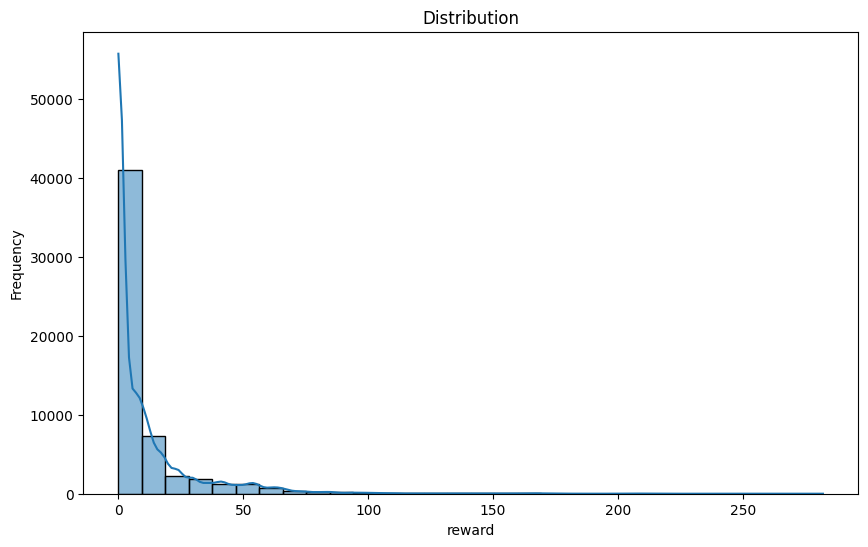

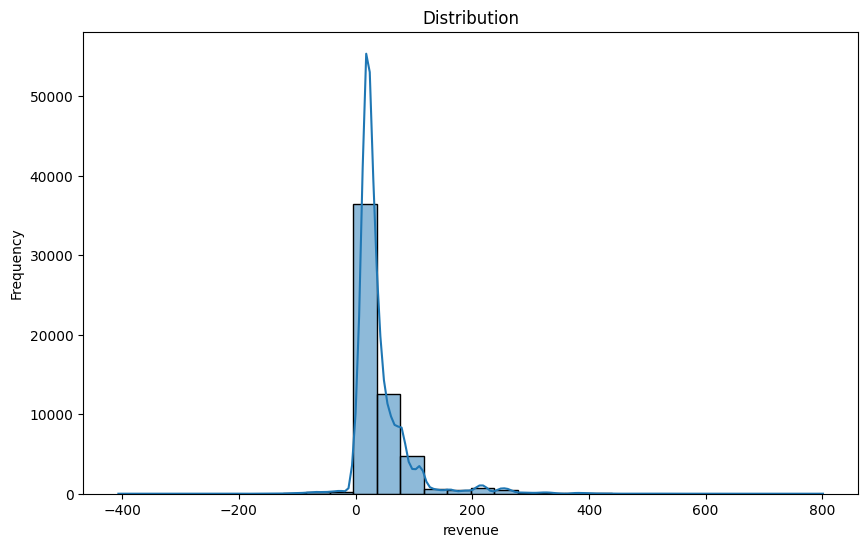

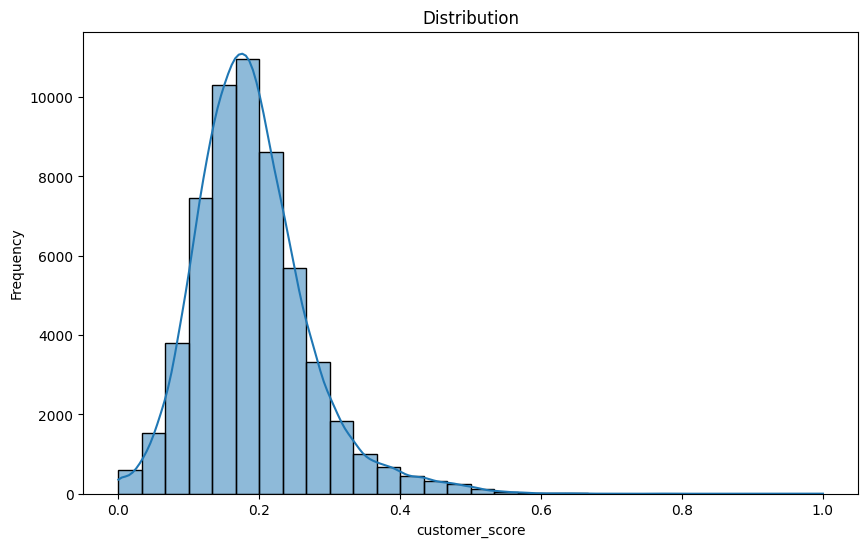

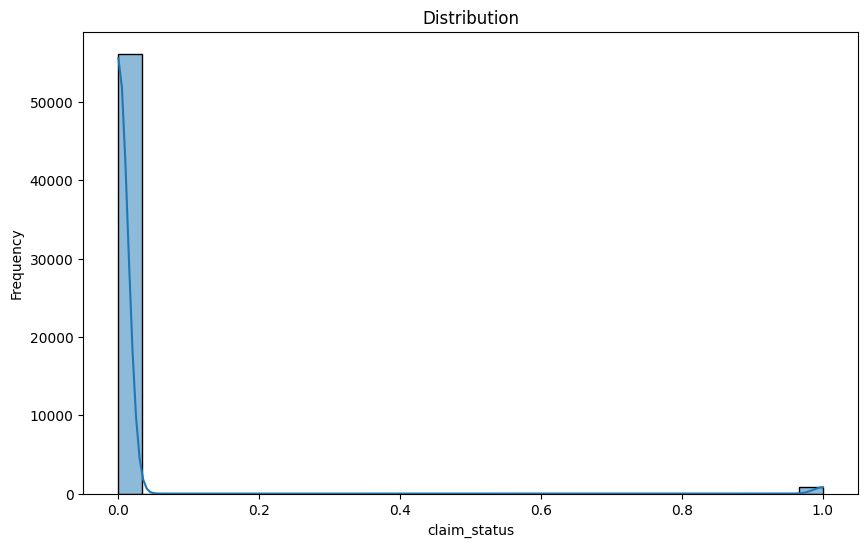

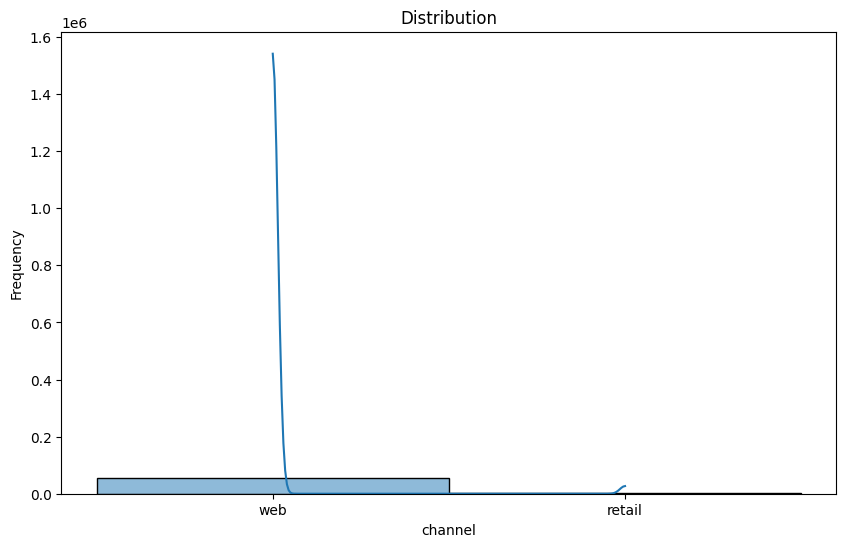

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=INS, x= 'reward', bins=30, kde=True)
plt.title('Distribution')
plt.xlabel('reward')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=INS, x= 'revenue', bins=30, kde=True)
plt.title('Distribution')
plt.xlabel('revenue')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=INS, x= 'customer_score', bins=30, kde=True)
plt.title('Distribution')
plt.xlabel('customer_score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=INS, x= 'claim_status', bins=30, kde=True)
plt.title('Distribution')
plt.xlabel('claim_status')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=INS, x= 'channel', bins=30, kde=True)
plt.title('Distribution')
plt.xlabel('channel')
plt.ylabel('Frequency')
plt.show()

In [16]:
# define & remove problematic variables from the dataset 
# i'm not sure abt removing 'reward','revenue' as they have some distribution still and maybe it would make sense to make then binary or maybe to combine them as they are correlated too much 

variables_nzv = INS[['channel']]

print(variables_nzv)



      channel
0         web
1         web
2         web
3         web
4         web
...       ...
56988     web
56989     web
56990     web
56991     web
56992     web

[56993 rows x 1 columns]


In [17]:
INS.drop(variables_nzv, axis = 1, inplace = True)
INS.head(10)


,reward,claim_status,person_gender,entity_type,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
0,0.000000,0,9b2d5b46,type_a,0,agt_0004,0.284509,50b3e71e,51,united states,105.459587,SecurePlan Flex,21
1,18.428627,0,9b2d5b46,type_a,0,agt_0001,0.207538,96d6c6df,32,Other,30.433459,DriveSafe Rental Addon,6
2,0.000000,0,9b2d5b46,type_a,1,agt_0004,0.300461,50b3e71e,38,Other,78.728474,TripGuard Cancel,84
3,0.000000,0,9b2d5b46,type_a,0,agt_0004,0.132404,50b3e71e,30,thailand,17.146843,TripGuard Cancel,39
4,0.000000,0,9b2d5b46,type_a,2,agt_0004,0.070443,50b3e71e,37,viet nam,10.476416,TripGuard Cancel,48
5,41.613029,0,9b2d5b46,type_a,1,agt_0001,0.288280,96d6c6df,30,australia,68.698795,DriveSafe Rental Addon,59
6,46.687680,0,9b2d5b46,type_a,1,agt_0001,0.140587,96d6c6df,23,Other,79.426319,DriveSafe Rental Addon,37
7,0.000000,0,9b2d5b46,type_a,1,agt_0004,0.189089,50b3e71e,38,malaysia,20.088002,SecurePlan OneWay,18
8,10.186860,0,f67ab10a,type_b,1,agt_0002,0.097472,7b5dbb09,35,indonesia,28.631036,TravelShield Basic,10
9,9.335454,0,f67ab10a,type_b,2,agt_0005,0.083457,99ede4e4,28,singapore,37.609526,TravelShield Core,138


In [18]:
INS_test.drop(variables_nzv, axis = 1, inplace = True)
INS_test.head(10)

,reward,person_gender,entity_type,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
0,84.316320,9b2d5b46,type_a,2,agt_0001,0.009257,96d6c6df,31,ireland,-141.716239,DriveSafe Rental Addon,73
1,45.884363,9b2d5b46,type_a,0,agt_0001,0.108049,96d6c6df,29,australia,82.225268,DriveSafe Rental Addon,25
2,0.000000,9b2d5b46,type_a,2,agt_0004,0.108814,50b3e71e,26,indonesia,10.247118,TripGuard Cancel,6
3,29.363482,f67ab10a,type_b,1,agt_0002,0.215505,7b5dbb09,32,france,83.483247,TravelShield Value,73
4,12.440951,08f27188,type_b,0,agt_0005,0.194798,99ede4e4,26,singapore,46.679372,TravelShield Plus,32
5,10.554589,f67ab10a,type_a,1,agt_0015,0.318590,5d630515,59,thailand,29.677038,CruiseSafe Trip,7
6,23.032416,9b2d5b46,type_a,0,agt_0001,0.260454,96d6c6df,34,new zealand,37.670204,DriveSafe Rental Addon,71
7,0.593061,9b2d5b46,type_b,1,agt_0008,0.196252,b5e4bb23,48,singapore,2.190958,TripGuard TicketCover,3
8,6.348724,08f27188,type_b,1,agt_0002,0.190387,7b5dbb09,52,thailand,17.234293,TravelShield Basic,14
9,6.527074,08f27188,type_b,2,agt_0002,0.175124,7b5dbb09,37,indonesia,17.992485,TravelShield Basic,163


### Correlation check for numeric variables 

                        reward  claim_status  support_interactions  \
reward                1.000000      0.099609              0.020915   
claim_status          0.099609      1.000000              0.004219   
support_interactions  0.020915      0.004219              1.000000   
customer_score        0.368217      0.056318              0.010134   
person_age            0.120739     -0.011507              0.005165   
revenue               0.652891      0.134837              0.026635   
trip_length           0.356496      0.077680              0.044720   

                      customer_score  person_age   revenue  trip_length  
reward                      0.368217    0.120739  0.652891     0.356496  
claim_status                0.056318   -0.011507  0.134837     0.077680  
support_interactions        0.010134    0.005165  0.026635     0.044720  
customer_score              1.000000    0.643153  0.468854     0.201912  
person_age                  0.643153    1.000000  0.037435     0.0049

<Axes: >

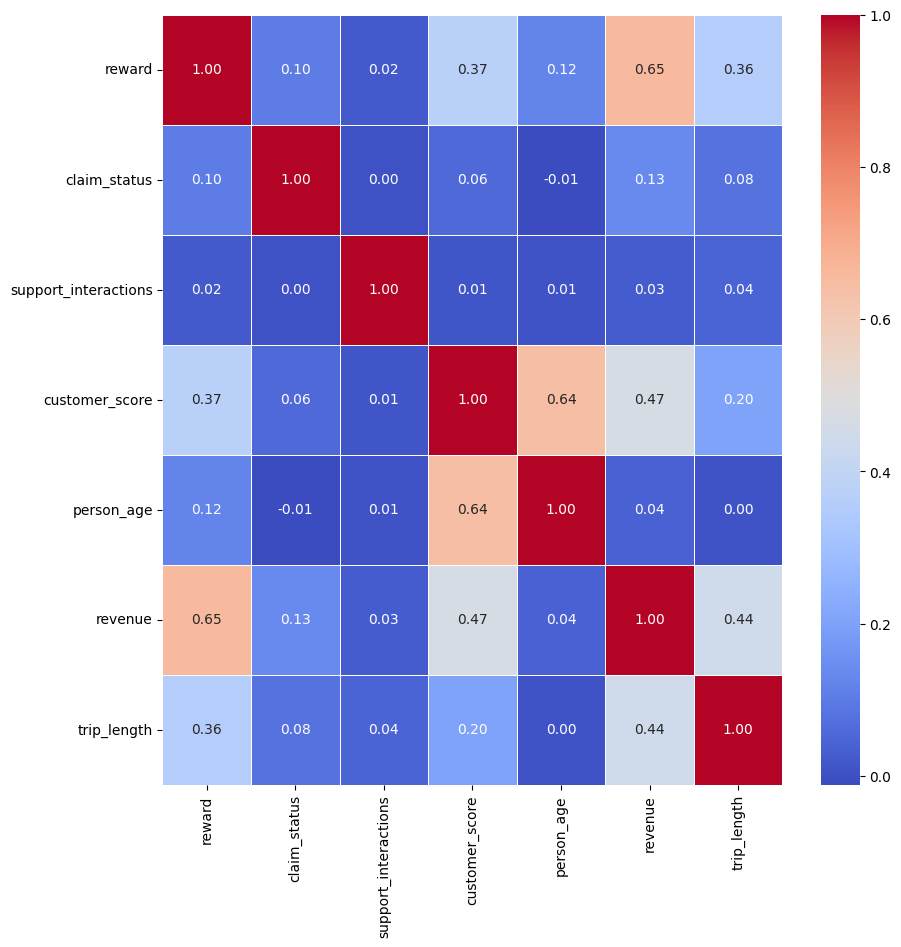

In [19]:
INS_numeric_columns = INS.select_dtypes(include=[np.number]).columns 

INS_correlations = INS[INS_numeric_columns].corr(method = 'pearson')

# Display the correlation matrix
print(INS_correlations)

plt.figure(figsize=(10, 10))

sns.heatmap(INS_correlations,
            annot = True,
            cmap = "coolwarm",
            fmt = ".2f",
            linewidths = 0.5)

customer_score & person_age: 0.64 – moderate correlation, not problematic yet.

revenue & reward: 0.65 – high-ish, but still below the 0.8 threshold.

customer_score & revenue: 0.47

All other correlations are low.



# Encoding of predictors


In [20]:
# one-hot encoding for train data

nominal_variables_for_enc = ['person_gender', 'entity_type']

# one-hot encode nominal variables and overwrite INS
INS_encoded = pd.get_dummies(
    INS,
    columns=nominal_variables_for_enc,
    drop_first=True,  # Reduces multicollinearity
    dtype=int         # Encodes as integers (0/1)
)



In [21]:

# one-hot encoding for test 

INS_test_encoded = pd.get_dummies(
    INS_test,
    columns=nominal_variables_for_enc,
    drop_first=True,  # Reduces multicollinearity
    dtype=int         # Encodes as integers (0/1)
)

In [26]:
INS_encoded.head()

,reward,claim_status,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b
0,0.000000,0,0,agt_0004,0.284509,50b3e71e,51,united states,105.459587,SecurePlan Flex,21,1,0,0
1,18.428627,0,0,agt_0001,0.207538,96d6c6df,32,Other,30.433459,DriveSafe Rental Addon,6,1,0,0
2,0.000000,0,1,agt_0004,0.300461,50b3e71e,38,Other,78.728474,TripGuard Cancel,84,1,0,0
3,0.000000,0,0,agt_0004,0.132404,50b3e71e,30,thailand,17.146843,TripGuard Cancel,39,1,0,0
4,0.000000,0,2,agt_0004,0.070443,50b3e71e,37,viet nam,10.476416,TripGuard Cancel,48,1,0,0


In [27]:
INS_test_encoded.head()

,reward,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b
0,84.316320,2,agt_0001,0.009257,96d6c6df,31,ireland,-141.716239,DriveSafe Rental Addon,73,1,0,0
1,45.884363,0,agt_0001,0.108049,96d6c6df,29,australia,82.225268,DriveSafe Rental Addon,25,1,0,0
2,0.000000,2,agt_0004,0.108814,50b3e71e,26,indonesia,10.247118,TripGuard Cancel,6,1,0,0
3,29.363482,1,agt_0002,0.215505,7b5dbb09,32,france,83.483247,TravelShield Value,73,0,1,1
4,12.440951,0,agt_0005,0.194798,99ede4e4,26,singapore,46.679372,TravelShield Plus,32,0,0,1


In [22]:
# frequency encoding 

cols_to_encode = ['location', 'agent_id', 'entity_a', 'product_id']

# Calculate frequencies and replace values for train 
for col in cols_to_encode:
    freq = INS_encoded[col].value_counts().to_dict()  # Get counts for each category
    INS_encoded[f'{col}_freq'] = INS_encoded[col].map(freq)   # Map counts to new column
    
INS_encoded.drop(cols_to_encode, axis=1, inplace=True)  # Remove original categorical columns




In [23]:
INS_encoded.head()

,reward,claim_status,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b,location_freq,agent_id_freq,entity_a_freq,product_id_freq
0,0.000000,0,0,0.284509,51,105.459587,21,1,0,0,2299,31663,31663,11872
1,18.428627,0,0,0.207538,32,30.433459,6,1,0,0,6681,7713,7713,7713
2,0.000000,0,1,0.300461,38,78.728474,84,1,0,0,6681,31663,31663,16795
3,0.000000,0,0,0.132404,30,17.146843,39,1,0,0,5303,31663,31663,16795
4,0.000000,0,2,0.070443,37,10.476416,48,1,0,0,1482,31663,31663,16795


In [24]:
# Calculate frequencies and replace values for test 
for cols in cols_to_encode:
    freq = INS_test_encoded[cols].value_counts().to_dict()  # Get counts for each category
    INS_test_encoded[f'{cols}_freq'] = INS_test_encoded[cols].map(freq)   # Map counts to new column
    
INS_test_encoded.drop(cols_to_encode, axis=1, inplace=True)  # Remove original categorical columns

In [31]:
INS_test_encoded.head()

,reward,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b,location_freq,agent_id_freq,entity_a_freq,product_id_freq
0,84.316320,2,0.009257,31,-141.716239,73,1,0,0,12,867,867,867
1,45.884363,0,0.108049,29,82.225268,25,1,0,0,371,867,867,867
2,0.000000,2,0.108814,26,10.247118,6,1,0,0,345,3456,3456,1835
3,29.363482,1,0.215505,32,83.483247,73,0,1,1,51,646,646,283
4,12.440951,0,0.194798,26,46.679372,32,0,0,1,1313,823,823,218


# Standartization of what is not binary 


In [25]:
print(INS_encoded.columns.tolist())

['reward', 'claim_status', 'support_interactions', 'customer_score', 'person_age', 'revenue', 'trip_length', 'person_gender_9b2d5b46', 'person_gender_f67ab10a', 'entity_type_type_b', 'location_freq', 'agent_id_freq', 'entity_a_freq', 'product_id_freq']


In [26]:
#define numeric cols for scaling
numerical_cols = [
    'reward', 'support_interactions', 'customer_score', 'person_age',
    'revenue', 'trip_length', 'location_freq', 'agent_id_freq',
    'entity_a_freq', 'product_id_freq'
]

# Transform train data
scaler = StandardScaler()
INS_encoded[numerical_cols] = scaler.fit_transform(INS_encoded[numerical_cols])

In [27]:
# Transform test data
INS_test_encoded[numerical_cols] = scaler.transform(INS_test_encoded[numerical_cols])



In [35]:
INS_encoded.head()

,reward,claim_status,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b,location_freq,agent_id_freq,entity_a_freq,product_id_freq
0,-0.494922,0,-1.185067,1.177678,0.896806,1.327408,-0.286188,1,0,0,-0.861320,0.887297,0.887297,0.398867
1,0.436242,0,-1.185067,0.223184,-0.610733,-0.211628,-0.438227,1,0,0,0.318297,-0.975734,-0.975734,-0.330913
2,-0.494922,0,-0.101767,1.375492,-0.134668,0.779063,0.352378,1,0,0,0.318297,0.887297,0.887297,1.262706
3,-0.494922,0,-1.185067,-0.708528,-0.769421,-0.484181,-0.103740,1,0,0,-0.052655,0.887297,0.887297,1.262706
4,-0.494922,0,0.981534,-1.476895,-0.214012,-0.621013,-0.012517,1,0,0,-1.081254,0.887297,0.887297,1.262706


In [36]:
INS_test_encoded.head()

,reward,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b,location_freq,agent_id_freq,entity_a_freq,product_id_freq
0,3.765426,0.981534,-2.235636,-0.690077,-3.742991,0.240882,1,0,0,-1.476972,-1.508273,-1.508273,-1.532180
1,1.823530,-1.185067,-1.010549,-0.848765,0.850794,-0.245644,1,0,0,-1.380331,-1.508273,-1.508273,-1.532180
2,-0.494922,0.981534,-1.001067,-1.086798,-0.625717,-0.438227,1,0,0,-1.387330,-1.306879,-1.306879,-1.362325
3,0.988761,-0.101767,0.321980,-0.610733,0.876600,0.240882,0,1,1,-1.466473,-1.525464,-1.525464,-1.634654
4,0.133696,-1.185067,0.065199,-1.086798,0.121630,-0.174692,0,0,1,-1.126748,-1.511695,-1.511695,-1.646060


# Correlation check after features transformation 

                          reward  claim_status  support_interactions  \
reward                  1.000000      0.099609              0.020915   
claim_status            0.099609      1.000000              0.004219   
support_interactions    0.020915      0.004219              1.000000   
customer_score          0.368217      0.056318              0.010134   
person_age              0.120739     -0.011507              0.005165   
revenue                 0.652891      0.134837              0.026635   
trip_length             0.356496      0.077680              0.044720   
person_gender_9b2d5b46 -0.279630     -0.109433             -0.005718   
person_gender_f67ab10a  0.183492      0.083986             -0.000263   
entity_type_type_b      0.178973      0.100194              0.004829   
location_freq           0.098059      0.106939              0.005732   
agent_id_freq          -0.537037     -0.078616             -0.005239   
entity_a_freq          -0.537037     -0.078616             -0.00

<Axes: >

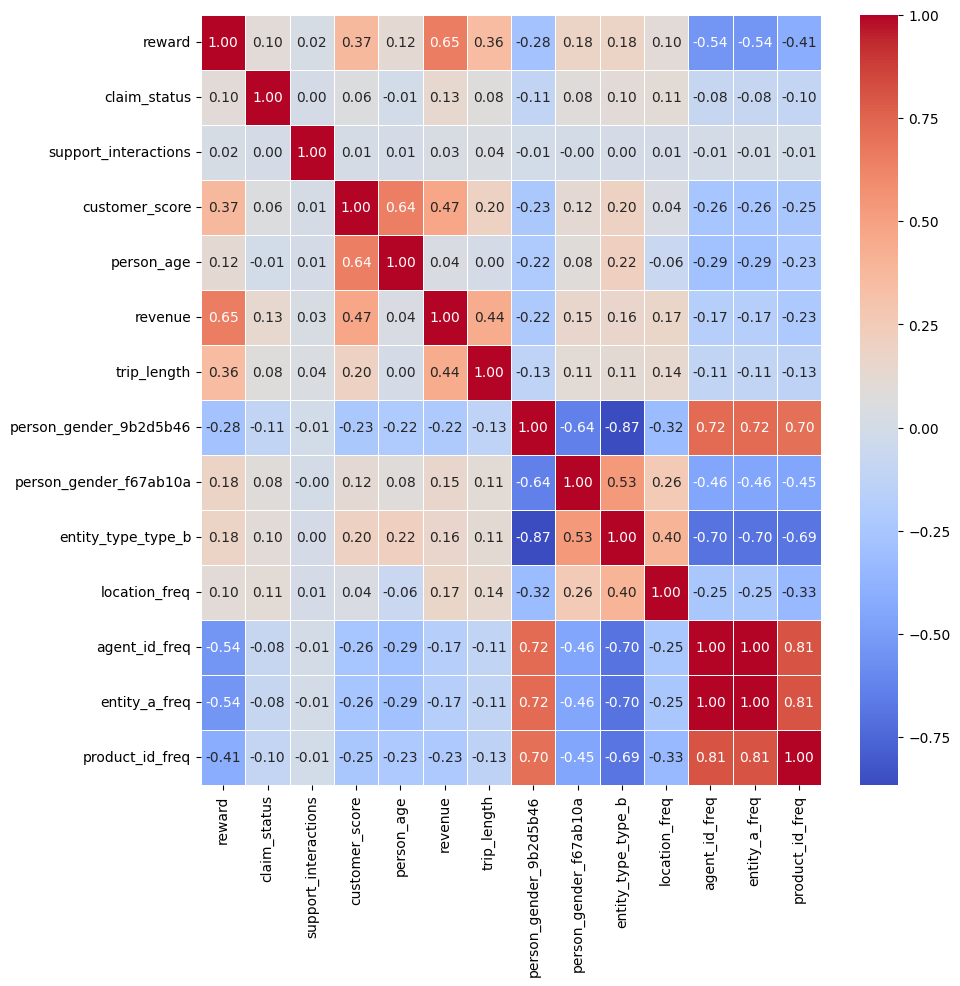

In [28]:

INS_cor = INS_encoded.corr(method = 'pearson')

# Display the correlation matrix
print(INS_cor)

plt.figure(figsize=(10, 10))

sns.heatmap(INS_cor,
            annot = True,
            cmap = "coolwarm",
            fmt = ".2f",
            linewidths = 0.5)

agent_id_freq and entity_a_freq: perfect correlation (1.0)

agent_id_freq and product_id_freq: high correlation (~0.81)

entity_a_freq and product_id_freq: high correlation (~0.81)

customer_score and person_age: strong correlation (~0.64)

 'agent_id_freq' and 'entity_a_freq' and 'product_id_freq' are highly correlated (over 0.80). I'd leave  'agent_id_freq' to make less dimentions as other features i'd assume less important to the main variable 


In [29]:
INS_encoded.drop('entity_a_freq', axis=1, inplace=True)
INS_encoded.drop('product_id_freq', axis=1, inplace=True)

In [30]:
INS_test_encoded.drop('entity_a_freq', axis=1, inplace=True)
INS_test_encoded.drop('product_id_freq', axis=1, inplace=True)

                          reward  claim_status  support_interactions  \
reward                  1.000000      0.099609              0.020915   
claim_status            0.099609      1.000000              0.004219   
support_interactions    0.020915      0.004219              1.000000   
customer_score          0.368217      0.056318              0.010134   
person_age              0.120739     -0.011507              0.005165   
revenue                 0.652891      0.134837              0.026635   
trip_length             0.356496      0.077680              0.044720   
person_gender_9b2d5b46 -0.279630     -0.109433             -0.005718   
person_gender_f67ab10a  0.183492      0.083986             -0.000263   
entity_type_type_b      0.178973      0.100194              0.004829   
location_freq           0.098059      0.106939              0.005732   
agent_id_freq          -0.537037     -0.078616             -0.005239   

                        customer_score  person_age   revenue  t

<Axes: >

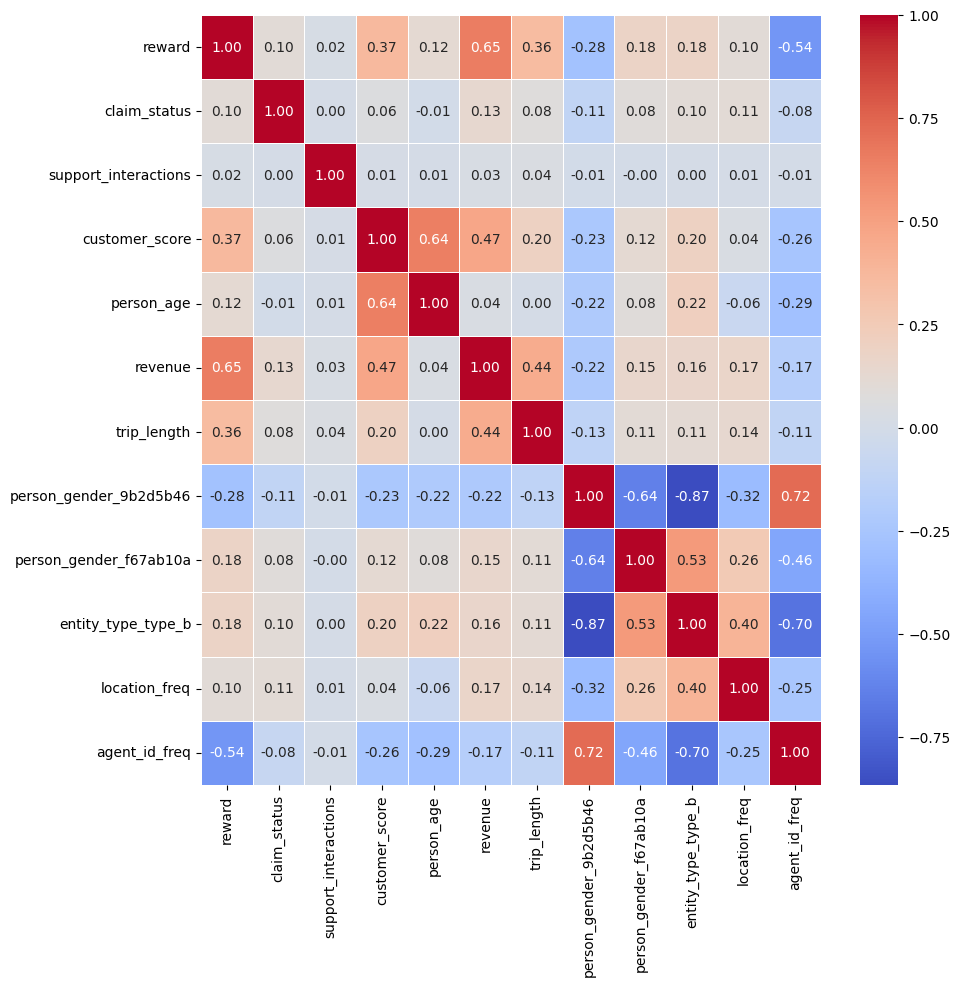

In [31]:
INS_cor  = INS_encoded.corr(method = 'pearson')

# Display the correlation matrix
print(INS_cor)

plt.figure(figsize=(10, 10))

sns.heatmap(INS_cor,
            annot = True,
            cmap = "coolwarm",
            fmt = ".2f",
            linewidths = 0.5)

In [41]:
INS_encoded.head()

,reward,claim_status,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b,location_freq,agent_id_freq
0,-0.494922,0,-1.185067,1.177678,0.896806,1.327408,-0.286188,1,0,0,-0.861320,0.887297
1,0.436242,0,-1.185067,0.223184,-0.610733,-0.211628,-0.438227,1,0,0,0.318297,-0.975734
2,-0.494922,0,-0.101767,1.375492,-0.134668,0.779063,0.352378,1,0,0,0.318297,0.887297
3,-0.494922,0,-1.185067,-0.708528,-0.769421,-0.484181,-0.103740,1,0,0,-0.052655,0.887297
4,-0.494922,0,0.981534,-1.476895,-0.214012,-0.621013,-0.012517,1,0,0,-1.081254,0.887297


In [42]:
INS_test_encoded.head()

,reward,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_b,location_freq,agent_id_freq
0,3.765426,0.981534,-2.235636,-0.690077,-3.742991,0.240882,1,0,0,-1.476972,-1.508273
1,1.823530,-1.185067,-1.010549,-0.848765,0.850794,-0.245644,1,0,0,-1.380331,-1.508273
2,-0.494922,0.981534,-1.001067,-1.086798,-0.625717,-0.438227,1,0,0,-1.387330,-1.306879
3,0.988761,-0.101767,0.321980,-0.610733,0.876600,0.240882,0,1,1,-1.466473,-1.525464
4,0.133696,-1.185067,0.065199,-1.086798,0.121630,-0.174692,0,0,1,-1.126748,-1.511695


# Distribution of the dependent variable

Lets check the distribution (histogram) of the dependent variable "claim_status".



<Axes: xlabel='claim_status', ylabel='Count'>

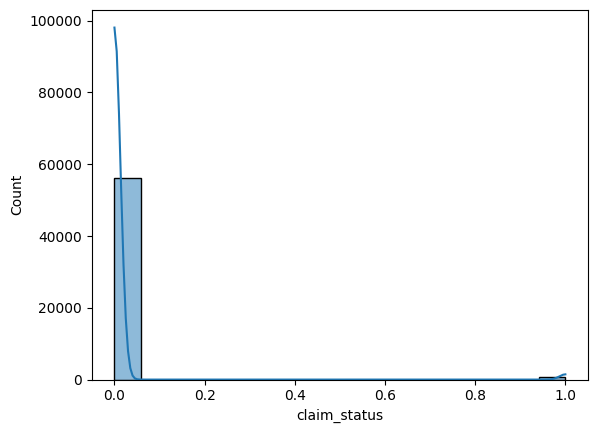

In [43]:
# Original distribution
sns.histplot(INS["claim_status"], kde = True)


# Unique values of numeric variable



In [32]:
numeric_variables = INS.select_dtypes(include=[np.number]).columns

for col in numeric_variables:
    unique_vals = INS[col].unique()
    n_unique = len(unique_vals)
    print(f"Column '{col}' has {n_unique} unique values.")

    # If a variable has no more than 5 unique values, print a frequency table
    if n_unique <= 5:
        print(f"Frequency table for '{col}':")
        print(INS[col].value_counts(dropna = False), "\n")

Column 'reward' has 25246 unique values.
Column 'claim_status' has 2 unique values.
Frequency table for 'claim_status':
claim_status
0    56159
1      834
Name: count, dtype: int64 

Column 'support_interactions' has 7 unique values.
Column 'customer_score' has 56862 unique values.
Column 'person_age' has 74 unique values.
Column 'revenue' has 55300 unique values.
Column 'trip_length' has 448 unique values.


# SMOTE Tomek Links to fix imbalanced target variable

Since we have very imbalanced target variable, we need to apply SMOTE Tomek

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVC  # For classification (not SVR)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from imblearn.combine import SMOTETomek  # For handling class imbalance
from imblearn.pipeline import Pipeline  # To combine SMOTE and model

In [48]:

X = INS_encoded.drop("claim_status", axis=1)
y = INS_encoded["claim_status"]

# Split data before resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE + Tomek
smt = SMOTETomek()

#Fit and resample 
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)


In [49]:
Xy_test_encoded = pd.concat([X_train_resampled, y_train_resampled], axis = 1)
print(Xy_test_encoded['claim_status'].value_counts()) # check target variable distribution

claim_status
0    44847
1    44847
Name: count, dtype: int64


# SVM 

In [50]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', random_state=42)  # 'rbf' works well for most cases
model.fit(X_train_resampled, y_train_resampled) 
          

SVC(random_state=42)

In [51]:

from sklearn.metrics import classification_report, balanced_accuracy_score, recall_score

y_val_pred = model.predict(X_test)

print(classification_report(y_test, y_val_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_val_pred))
print("Recall:", recall_score(y_test, y_val_pred))


              precision    recall  f1-score   support

           0       0.99      0.83      0.90     11245
           1       0.05      0.66      0.09       154

    accuracy                           0.83     11399
   macro avg       0.52      0.74      0.50     11399
weighted avg       0.98      0.83      0.89     11399

Balanced Accuracy: 0.7417059818793923
Recall: 0.6558441558441559


              precision    recall  f1-score   support

           0     0.9943    0.8276    0.9033     11245
           1     0.0495    0.6558    0.0921       154

    accuracy                         0.8252     11399
   macro avg     0.5219    0.7417    0.4977     11399
weighted avg     0.9816    0.8252    0.8924     11399

Balanced Accuracy: 0.7417059818793923
Recall (Minority class): 0.6558441558441559
Precision: 0.049509803921568625
F1 Score: 0.09206927985414767
ROC AUC: 0.8021244651302456
PR AUC (Average Precision): 0.07270345917232539


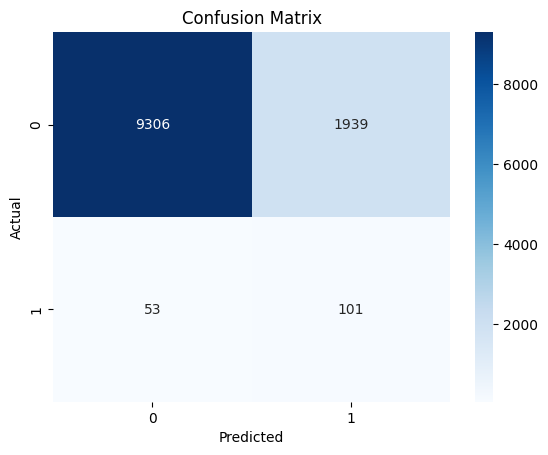

In [52]:
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions (probabilities needed for AUC)
y_val_pred = model.predict(X_test)
y_val_proba = model.decision_function(X_test)  # For SVC with probability=False

# Basic classification metrics
print(classification_report(y_test, y_val_pred, digits=4))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_val_pred))
print("Recall (Minority class):", recall_score(y_test, y_val_pred))
print("Precision:", precision_score(y_test, y_val_pred))
print("F1 Score:", f1_score(y_test, y_val_pred))

# AUC Metrics (threshold-independent)
print("ROC AUC:", roc_auc_score(y_test, y_val_proba))
print("PR AUC (Average Precision):", average_precision_score(y_test, y_val_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
y_pred_test = model.predict(INS_test_encoded)
predictions_df = pd.DataFrame({
    'predicted': y_pred_test
})

In [ ]:
predictions_df.to_csv("svm_test_predictions.csv", index=False)

knn

In [54]:
from sklearn.neighbors import KNeighborsClassifier

#X_train, X_val, y_train, y_val = train_test_split(X_smote_svm, y_smote_svm, test_size=0.2, random_state=42)
# Initialize and train the model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_KNN = knn_model.predict(X_test)
y_proba_KNN = knn_model.predict_proba(X_test)[:, 1]

print("\nk-Nearest Neighbors (k-NN)")
print("---------------------------")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_KNN):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_KNN):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_KNN):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_KNN):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_KNN):.3f}")



k-Nearest Neighbors (k-NN)
---------------------------
Accuracy:  0.986
Precision: 0.222
Recall:    0.013
F1 Score:  0.025
ROC AUC:   0.558


Classification Report:

              precision    recall  f1-score   support

           0     0.9867    0.9994    0.9930     11245
           1     0.2222    0.0130    0.0245       154

    accuracy                         0.9861     11399
   macro avg     0.6044    0.5062    0.5088     11399
weighted avg     0.9763    0.9861    0.9799     11399

Balanced Accuracy: 0.5061822570493091
Recall (Minority class): 0.012987012987012988
Precision: 0.2222222222222222
F1 Score: 0.024539877300613498
ROC AUC: 0.5580846898765974
PR AUC (Average Precision): 0.024345288674800077


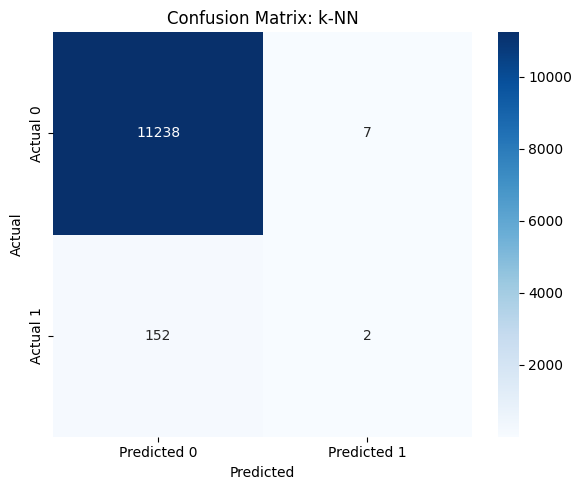

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Basic classification metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred_KNN, digits=4))

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_KNN))
print("Recall (Minority class):", recall_score(y_test, y_pred_KNN))
print("Precision:", precision_score(y_test, y_pred_KNN))
print("F1 Score:", f1_score(y_test, y_pred_KNN))

# AUC metrics
print("ROC AUC:", roc_auc_score(y_test, y_proba_KNN))
print("PR AUC (Average Precision):", average_precision_score(y_test, y_proba_KNN))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_KNN)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: k-NN")
plt.tight_layout()
plt.show()